In [267]:
import random
import os
from dataset import dataset
import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import numpy as np


In [268]:
def make_plots(f1_scores, loss_scores, names_list):
    f1_data = [f1_scores[i] for i in range(len(f1_scores))]
    loss_data = [loss_scores[i] for i in range(len(loss_scores))]

    positions = np.arange(len(f1_scores))
    width = 0.4

    plt.figure(figsize=(8, 6))
    plt.boxplot(f1_data, positions=positions, widths=width, patch_artist=True,
                boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'),
                whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                flierprops=dict(markerfacecolor='blue', marker='o'))
    plt.xticks(positions, names_list)
    plt.xlabel('Datasets')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores Across Datasets')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.boxplot(loss_data, positions=positions, widths=width, patch_artist=True,
                boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='red'),
                whiskerprops=dict(color='red'), capprops=dict(color='red'),
                flierprops=dict(markerfacecolor='red', marker='o'))
    plt.xticks(positions, names_list)
    plt.xlabel('Datasets')
    plt.ylabel('0/1 Loss Score')
    plt.title('0/1 Loss Scores Across Datasets')
    plt.tight_layout()
    plt.show()

In [269]:
class algorithm:
    def __init__(self, data_array:dataset, which_data:str):
        # The algorithm takes in a pre-processed dataset object, there shouldn't be much to do with the constructor except maybe a setter for the dataset
        self.data_array = data_array.partitions
        self.feature_probs = {}
        self.class_priors = {}
        self.predictions = []
        self.answers = []

        # Determines label type
        cancer_labels = ['2','4']
        glass_labels = ['1','2','3','4','5','6','7']
        iris_labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
        soybean_labels = ['D1','D2','D3','D4']
        votes_labels = ['republican','democrat']
        if (which_data == 'cancer'):
            self.labels = cancer_labels
        elif (which_data == 'glass'):
            self.labels = glass_labels
        elif (which_data == 'iris'):
            self.labels = iris_labels
        elif (which_data == 'soybean'):
            self.labels = soybean_labels
        elif (which_data == 'votes'):
            self.labels = votes_labels
       
        self.labels_2d = []
        for fold_i in range(len(self.data_array)):
            self.labels_2d.append([])
            for example_i in range(len(self.data_array[fold_i])):
                self.labels_2d[fold_i].append(self.data_array[fold_i][example_i][-1])

    def train(self):
        num_folds = len(self.data_array)
        
        '''
        # Q() calculates the class prior probabilities, this create be an array 10 * the # of classes in the datset (10 for each validation set).
        self.all_class_counts = []
        self.class_counts = [0] * len(self.labels)
        self.probs = [0] * len(self.labels)
        self.example_count = 0
        self.class_probs = []

        self.class_counts = [0] * len(self.labels)
        self.example_count = 0
        for partition in range(10):
            for example in range(len(self.data_array[partition])):
                self.example_count += 1
                for label in range(len(self.labels)):
                    if (self.data_array[partition][example][-1] == self.labels[label]):
                        self.class_counts[label] += 1
        for i, count in enumerate(self.class_counts):
            self.probs[i] = count/(self.example_count)
        self.all_class_counts.append(self.class_counts.copy())
        '''

        # Loop through each fold
        for fold_idx in range(num_folds):
            # Prepare training and validation data
            train_data, train_labels, test_data, test_labels = self._get_train_test(fold_idx)
            
            # Get the list of unique classes
            unique_classes = set(train_labels)
            
            # Initialize dictionaries for storing class priors and feature likelihoods
            class_counts = defaultdict(int)
            feature_counts = defaultdict(lambda: defaultdict(int))
            feature_totals = defaultdict(int)
            
            num_examples = len(train_labels)
            print(f"Nume_Examples: {num_examples}")
            
            # Print training data and labels to verify they are correctly loaded
            #train_data, train_labels, test_data, test_labels = self._get_train_test(fold_idx)
            #print(f"Training data for fold {fold_idx}: {train_data}")
            #print(f"Training labels for fold {fold_idx}: {train_labels}")

            # Step 1: Check the labels for the current fold
            print(f"Train labels for fold {fold_idx}: {train_labels}")

            # Step 1: Calculate priors and feature likelihoods
            class_counts = defaultdict(int)

            for example, label in zip(train_data, train_labels):
                class_counts[label] += 1  # Increment the count for the class
                for feature_idx, feature_value in enumerate(example):
                    feature_counts[label][feature_idx, feature_value] += 1
                    feature_totals[label] += 1

            # Debugging: Print out class counts to check if they are correct
            print(f"Class counts for fold {fold_idx}: {class_counts}")


            # Step 2: Calculate prior probabilities for each class (with Laplace smoothing)
            self.class_priors[fold_idx] = {}

            for cls in unique_classes:
                # Calculate prior probability with Laplace smoothing
                self.class_priors[fold_idx][cls] = (class_counts[cls] + 1) / (num_examples + len(unique_classes))

            # Debugging: Print out prior probabilities to verify
            print(f"Class priors for fold {fold_idx}: {self.class_priors[fold_idx]}")

            '''
            # Step 1: Calculate priors and feature likelihoods
            for example, label in zip(train_data, train_labels):
                class_counts[label] += 1
                for feature_idx, feature_value in enumerate(example):
                    feature_counts[label][feature_idx, feature_value] += 1
                    feature_totals[label] += 1

            # Step 2: Calculate prior probabilities for each class
            self.class_priors[fold_idx] = {cls: class_counts[cls] /  for c, cls in enumerate(unique_classes)}
            #print(f"Self.class_priors: {self.class_priors}")
            '''



            # Step 3: Calculate conditional probabilities P(feature | class)
            self.feature_probs[fold_idx] = defaultdict(lambda: defaultdict(float))
            for label in unique_classes:
                for feature, count in feature_counts[label].items():
                    self.feature_probs[fold_idx][label][feature] = (count + 1) / (feature_totals[label] + len(feature_counts[label]))

            # Step 4: Predict on the validation (test) set for the current fold
            fold_predictions = []
            for example in test_data:
                predicted_label = self.predict(example, fold_idx)
                fold_predictions.append(predicted_label)
            self.predictions.append(fold_predictions)

    def predict(self, example, fold_idx):
        """
        Predict the label of a single example using the trained model for a specific fold.
        """
        class_probs = {}
        unique_classes = set(self.class_priors[fold_idx].keys()).union(set(self.labels_2d[fold_idx]))

        # Step 1: Compute the joint probability for each class
        for label in unique_classes:
            # Start with the prior probability of the class
            if label in self.class_priors[fold_idx]:
                log_prob = math.log(self.class_priors[fold_idx][label])
            else:
                # Handle case where a class was not seen in training by applying Laplace smoothing
                log_prob = math.log(1 / (len(self.class_priors[fold_idx]) + 1))

            # Multiply by the likelihood of each feature
            for feature_idx, feature_value in enumerate(example):
                if (feature_idx, feature_value) in self.feature_probs[fold_idx][label]:
                    log_prob += math.log(self.feature_probs[fold_idx][label][(feature_idx, feature_value)])
                else:
                    # Handle the case of zero probability (unseen feature/class combination) by adding smoothing
                    log_prob += math.log(1 / (len(self.feature_probs[fold_idx][label]) + 1))

            class_probs[label] = log_prob

        # Step 2: Return the class with the highest probability
        if class_probs:
            return max(class_probs, key=class_probs.get)
        else:
            # Fallback in case class_probs is still empty for any reason
            return None  # or a default class, if you prefer

    
    def _get_train_test(self, fold_idx):
        """
        Helper method to split data into training and testing sets based on fold_idx.
        """
        test_data = self.data_array[fold_idx]
        test_labels = self.labels_2d[fold_idx]

        # Combine all other folds for training
        train_data = []
        train_labels = []
        for i in range(len(self.data_array)):
            if i != fold_idx:
                train_data.extend(self.data_array[i])
                train_labels.extend(self.labels_2d[i])

        return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)


    def calculate_loss(self):
        # This method will analyze the classification, and determine, TP, TN, FP, FN, F1 loss, 0/1 loss, etc.
        # These results need to be saved
        # We will also want to create a box plot where the x-axis is the dataset we worked with (10 datasets), and y axis is a performance metric (whatever we want). For each dataset there will be 10 datapoints in the box, each point represents the performance of one of the folds.
        self.zero_one_losses = []
        self.f1_scores = []
        for fold_index in range(10):
            test_fold = self.data_array[fold_index]

            true_positives = {label: 0 for label in self.labels}
            false_positives = {label: 0 for label in self.labels}
            false_negatives = {label: 0 for label in self.labels}
            correct_predictions = 0
            total_predictions = len(test_fold)


            for i in range(total_predictions):
                true_label = self.data_array[fold_index][i][-1]
                predicted_label = self.predictions[fold_index][i]


                if predicted_label == true_label:
                    correct_predictions += 1

                if predicted_label == true_label:
                    true_positives[true_label] += 1
                else:
                    false_positives[predicted_label] += 1
                    false_negatives[true_label] += 1
                
            #loss = (correct_predictions / total_predictions)
            loss = 1 - (correct_predictions / total_predictions)
            self.zero_one_losses.append(loss)



            f1_scores_per_class = []
            for label in self.labels:
                precision = true_positives[label] / (true_positives[label] + false_positives[label]) if (true_positives[label] + false_positives[label]) > 0 else 0
                recall = true_positives[label] / (true_positives[label] + false_negatives[label]) if (true_positives[label] + false_negatives[label]) > 0 else 0
                f1 = ((2 * (precision * recall)) / (precision + recall)) if (precision + recall) > 0 else 0
                f1_scores_per_class.append(f1)
            
            average_f1 = sum(f1_scores_per_class) / len(self.labels)
            self.f1_scores.append(average_f1)





In [270]:
cancer_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/cancer_nopre.csv', 'last', True)
glass_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/glass_nopre.csv', 'last', True)
glass_nopre.discretize(10, True)
votes_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/votes_nopre.csv', 'first', True)
iris_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/iris_nopre.csv', 'last', True)
iris_nopre.discretize(10, False)
soybean_nopre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/soybean_nopre.csv', 'last', True)

cancer_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/cancer_pre.csv', 'last', True)
glass_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/glass_pre.csv', 'last', True)
votes_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/votes_pre.csv', 'first', True)
iris_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/iris_pre.csv', 'last', True)
soybean_pre = dataset('/home/carlos/Machine_Learning_Practice/processed_data/soybean_pre.csv', 'last', True)

In [271]:
cancer_nopre_processing = algorithm(cancer_nopre, 'cancer')
glass_nopre_processing = algorithm(glass_nopre, 'glass')
votes_nopre_processing = algorithm(votes_nopre, 'votes')
iris_nopre_processing = algorithm(iris_nopre, 'iris')
soybean_nopre_processing = algorithm(soybean_nopre, 'soybean')

cancer_pre_processing = algorithm(cancer_pre, 'cancer')
glass_pre_processing = algorithm(glass_pre, 'glass')
votes_pre_processing = algorithm(votes_pre, 'votes')
iris_pre_processing = algorithm(iris_pre, 'iris')
soybean_pre_processing = algorithm(soybean_pre, 'soybean')

In [272]:
cancer_nopre_processing.train()
glass_nopre_processing.train()
votes_nopre_processing.train()
iris_nopre_processing.train()
soybean_nopre_processing.train()

cancer_pre_processing.train()
glass_pre_processing.train()
votes_pre_processing.train()
iris_pre_processing.train()
soybean_pre_processing.train()
print(f"Prior Probs:   {glass_nopre_processing.class_priors}")
print(f"Prior Probs:   {iris_nopre_processing.class_priors}")
print(f"Feature Probs: {iris_nopre_processing.feature_probs}")

Nume_Examples: 629
Train labels for fold 0: ['2' '2' '2' '4' '2' '4' '4' '4' '2' '4' '4' '4' '2' '4' '4' '4' '4' '4'
 '4' '2' '4' '2' '2' '4' '2' '4' '4' '2' '2' '2' '2' '4' '2' '4' '2' '2'
 '2' '4' '2' '2' '4' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '4' '2'
 '4' '2' '4' '2' '2' '4' '2' '2' '2' '2' '2' '2' '2' '4' '4' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '4' '2' '2' '4' '4' '4' '2' '4' '2' '2' '2' '4'
 '2' '4' '4' '2' '2' '2' '4' '2' '2' '4' '2' '4' '2' '4' '4' '2' '4' '4'
 '2' '4' '4' '2' '2' '2' '2' '2' '4' '4' '2' '2' '4' '4' '4' '4' '2' '2'
 '4' '2' '2' '2' '2' '4' '4' '2' '2' '2' '4' '4' '2' '2' '2' '2' '4' '2'
 '2' '2' '2' '4' '2' '4' '2' '2' '2' '4' '2' '2' '4' '2' '4' '2' '2' '2'
 '2' '2' '2' '4' '2' '2' '2' '4' '2' '2' '2' '2' '2' '2' '4' '2' '2' '2'
 '2' '4' '2' '2' '2' '2' '4' '2' '4' '4' '2' '2' '2' '2' '2' '4' '2' '2'
 '2' '2' '4' '4' '4' '2' '4' '4' '2' '2' '2' '2' '2' '2' '2' '2' '4' '2'
 '2' '4' '4' '2' '4' '2' '2' '2' '2' '2' '2' '2' '2' '4' '4' '4' '4' '4'
 '2' '4

In [277]:
cancer_nopre_processing.calculate_loss()
glass_nopre_processing.calculate_loss()
votes_nopre_processing.calculate_loss()
iris_nopre_processing.calculate_loss()
soybean_nopre_processing.calculate_loss()

cancer_pre_processing.calculate_loss()
glass_pre_processing.calculate_loss()
votes_pre_processing.calculate_loss()
iris_pre_processing.calculate_loss()
soybean_pre_processing.calculate_loss()


answers = []
for i in range(10):
    answers.append([])
    for j in range(len(soybean_nopre_processing.data_array[i])):
        answers[i].append(soybean_nopre_processing.data_array[i][j][-1])
print(f"Class Probs: {soybean_nopre_processing.class_priors}")
print(f"Feature Pro: {soybean_nopre_processing.feature_probs}")
print(f"Predictions: {soybean_nopre_processing.predictions}")
print(f"Answers:     {answers}")

Class Probs: {0: {'D1': 0.2391304347826087, 'D4': 0.34782608695652173, 'D2': 0.21739130434782608, 'D3': 0.1956521739130435}, 1: {'D1': 0.2391304347826087, 'D4': 0.32608695652173914, 'D2': 0.1956521739130435, 'D3': 0.2391304347826087}, 2: {'D1': 0.21739130434782608, 'D4': 0.34782608695652173, 'D2': 0.2391304347826087, 'D3': 0.1956521739130435}, 3: {'D1': 0.1956521739130435, 'D4': 0.34782608695652173, 'D2': 0.2391304347826087, 'D3': 0.21739130434782608}, 4: {'D1': 0.2391304347826087, 'D4': 0.34782608695652173, 'D2': 0.1956521739130435, 'D3': 0.21739130434782608}, 5: {'D1': 0.1956521739130435, 'D4': 0.3695652173913043, 'D2': 0.21739130434782608, 'D3': 0.21739130434782608}, 6: {'D1': 0.1956521739130435, 'D4': 0.391304347826087, 'D2': 0.2391304347826087, 'D3': 0.17391304347826086}, 7: {'D1': 0.19148936170212766, 'D4': 0.3404255319148936, 'D2': 0.23404255319148937, 'D3': 0.23404255319148937}, 8: {'D1': 0.23404255319148937, 'D4': 0.3404255319148936, 'D2': 0.19148936170212766, 'D3': 0.23404255

In [274]:
zero_one_list = [cancer_nopre_processing.zero_one_losses, cancer_pre_processing.zero_one_losses, votes_nopre_processing.zero_one_losses, votes_pre_processing.zero_one_losses, soybean_nopre_processing.zero_one_losses, soybean_pre_processing.zero_one_losses]
f1_scores_list = [cancer_nopre_processing.f1_scores, cancer_pre_processing.f1_scores, votes_nopre_processing.f1_scores, votes_pre_processing.f1_scores, soybean_nopre_processing.f1_scores, soybean_pre_processing.f1_scores]
names_list = ['','','','','','']
#make_plots(zero_one_list, f1_scores_list, names_list)

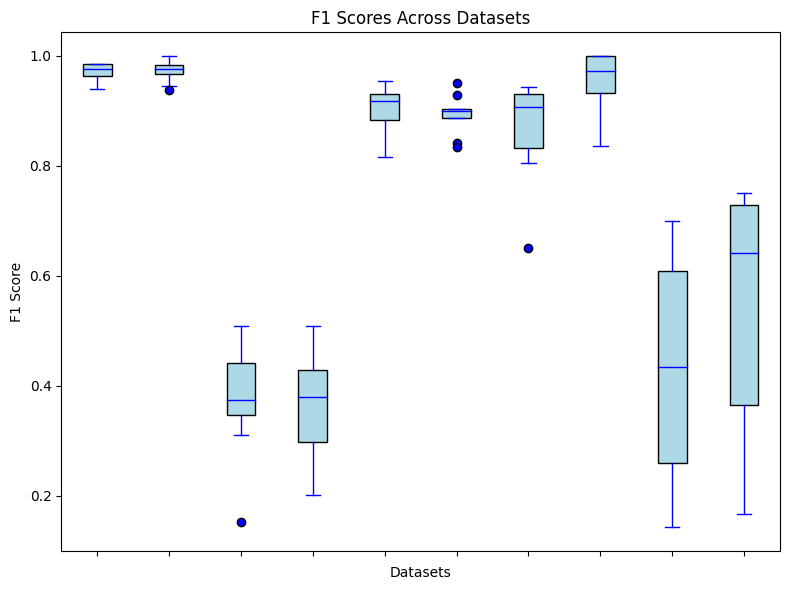

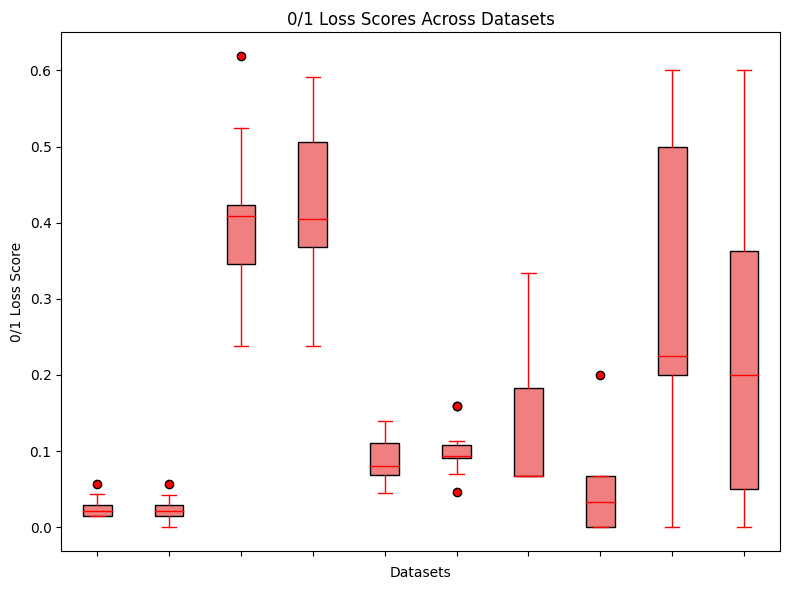

In [275]:
zero_one_list = [cancer_nopre_processing.zero_one_losses, cancer_pre_processing.zero_one_losses, glass_nopre_processing.zero_one_losses, glass_pre_processing.zero_one_losses, votes_nopre_processing.zero_one_losses, votes_pre_processing.zero_one_losses, iris_nopre_processing.zero_one_losses, iris_pre_processing.zero_one_losses, soybean_nopre_processing.zero_one_losses, soybean_pre_processing.zero_one_losses]
f1_scores_list = [cancer_nopre_processing.f1_scores, cancer_pre_processing.f1_scores, glass_nopre_processing.f1_scores, glass_pre_processing.f1_scores, votes_nopre_processing.f1_scores, votes_pre_processing.f1_scores, iris_nopre_processing.f1_scores, iris_pre_processing.f1_scores, soybean_nopre_processing.f1_scores, soybean_pre_processing.f1_scores]
names_list = ['','','','','','','','','','']
make_plots(f1_scores_list, zero_one_list, names_list)

In [276]:
my_list = [1,2,3,4,5,6,7,8,9,10]
for i in range(len(my_list)):
    rotated_list = my_list[i+1:] + my_list[:i+1]
    rotated_list = rotated_list[:-1]
    print(rotated_list)
    

[2, 3, 4, 5, 6, 7, 8, 9, 10]
[3, 4, 5, 6, 7, 8, 9, 10, 1]
[4, 5, 6, 7, 8, 9, 10, 1, 2]
[5, 6, 7, 8, 9, 10, 1, 2, 3]
[6, 7, 8, 9, 10, 1, 2, 3, 4]
[7, 8, 9, 10, 1, 2, 3, 4, 5]
[8, 9, 10, 1, 2, 3, 4, 5, 6]
[9, 10, 1, 2, 3, 4, 5, 6, 7]
[10, 1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
